# ***Agenda***
---
The goal on the behind of that project is to develop a model that analyse that plants leaf and identify that which stage of disease occur on that plant .Our stratigy of workig is :


1.  Load Data set
2.   Data Visualization
3.   Data Sepreration
4.   Data Augmentation
5.   Model Evaluation
6.   Model Performance
7.   Model Performance
8.   Model Prediction
9.   Saving  Model


















Import Necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import models
import matplotlib.pyplot as plt
import numpy as np


## **Load Data Set**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
# Variables
IMAGE_SIZE =256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH =50

In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## **Data Visualization**

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print("Images shape : ",image_batch.shape)

    print("Labels : ",labels_batch.numpy())


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]
(256, 256, 3)


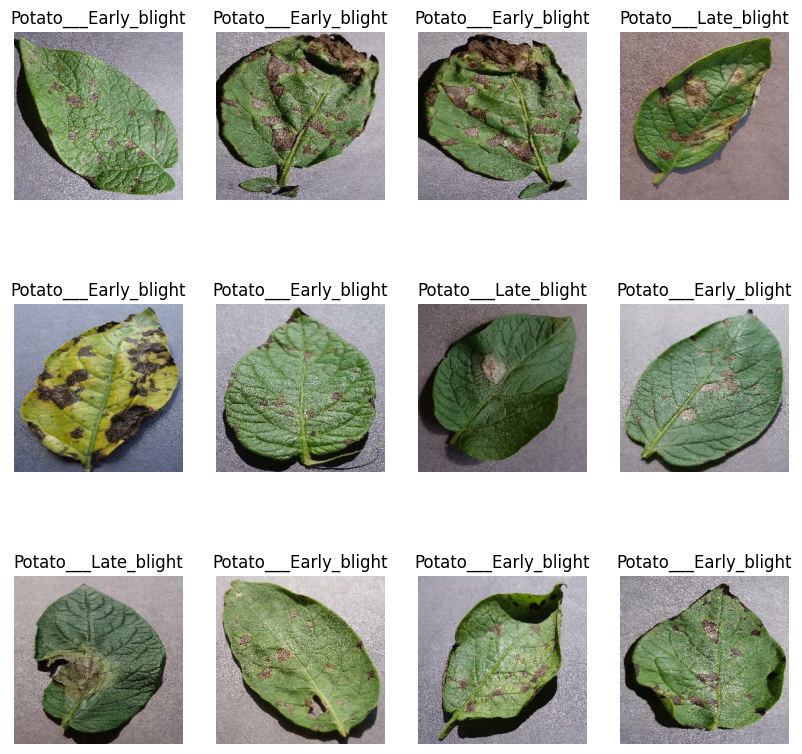

In [ ]:
plt.figure(figsize=(10, 10))

for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax =plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

## **Data Sepreration**
Split dataset into train ,test and validation parts


In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1
   ds_size = len(ds)
   if shuffle:
      ds = ds.shuffle(shuffle_size,seed=12)

 # Store size of train , test , valid
   train_size = int(train_split*ds_size)
   val_size = int(val_split*ds_size)
   test_size = int(test_split*ds_size)


# Split data set in to train , test  and validation
   train_ds = ds.take(train_size)
   val_ds  = ds.skip(train_size)
   test_ds = ds.skip(train_size).skip(val_size)

   return  train_ds , val_ds , test_ds
  #  print(train_ds)

# Calling function
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds) , len(val_ds) , len(test_ds) )

54 14 8


In [ ]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  keras.layers.Rescaling(1./255),
])

## **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## **Model Evaluation**

Using CNN for model training

In [ ]:
inputShape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=inputShape),  # Define the input shape here
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])

# model.build(input_shape=inputShape)


In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 164s 3s/step - loss: 0.9152 - accuracy: 0.5122 - val_loss: 0.8612 - val_accuracy: 0.4821
Epoch 2/10
54/54 [==============================] - 151s 3s/step - loss: 0.7376 - accuracy: 0.6516 - val_loss: 0.4774 - val_accuracy: 0.7879
Epoch 3/10
54/54 [==============================] - 149s 3s/step - loss: 0.3897 - accuracy: 0.8513 - val_loss: 0.3650 - val_accuracy: 0.8683
Epoch 4/10
54/54 [==============================] - 147s 3s/step - loss: 0.2385 - accuracy: 0.9005 - val_loss: 0.1678 - val_accuracy: 0.9241
Epoch 5/10
54/54 [==============================] - 149s 3s/step - loss: 0.2056 - accuracy: 0.9144 - val_loss: 0.1298 - val_accuracy: 0.9531
Epoch 6/10
54/54 [==============================] - 148s 3s/step - loss: 0.1765 - accuracy: 0.9340 - val_loss: 0.0778 - val_accuracy: 0.9777
Epoch 7/10
54/54 [==============================] - 146s 3s/step - loss: 0.1226 - accuracy: 0.9549 - val_loss: 0.1341 - val_accuracy: 0.9442
Epoch 8/10
54

## **Model Performance**

evaluate model performance via test part of data sets

In [ ]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 9s 690ms/step - loss: 0.2778 - accuracy: 0.9258


[0.2778380811214447, 0.92578125]

In [ ]:
history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history


{'loss': [0.9151937961578369,
  0.7375559210777283,
  0.3896564245223999,
  0.23854617774486542,
  0.20564275979995728,
  0.17650270462036133,
  0.12258284538984299,
  0.08773792535066605,
  0.1550021469593048,
  0.09284330159425735],
 'accuracy': [0.5121527910232544,
  0.6516203880310059,
  0.8512731194496155,
  0.9004629850387573,
  0.9143518805503845,
  0.9340277910232544,
  0.9548611044883728,
  0.9664351940155029,
  0.9467592835426331,
  0.9652777910232544],
 'val_loss': [0.8612366318702698,
  0.4773850440979004,
  0.3649960458278656,
  0.16777534782886505,
  0.129750594496727,
  0.07776696234941483,
  0.13411030173301697,
  0.6053637862205505,
  0.10796426236629486,
  0.210267573595047],
 'val_accuracy': [0.4821428656578064,
  0.7879464030265808,
  0.8683035969734192,
  0.9241071343421936,
  0.953125,
  0.9776785969734192,
  0.9441964030265808,
  0.8013392686843872,
  0.9486607313156128,
  0.9196428656578064]}

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [ ]:

history.history['loss'][:5] # show loss for first 5 epochs

[0.9151937961578369,
 0.7375559210777283,
 0.3896564245223999,
 0.23854617774486542,
 0.20564275979995728]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

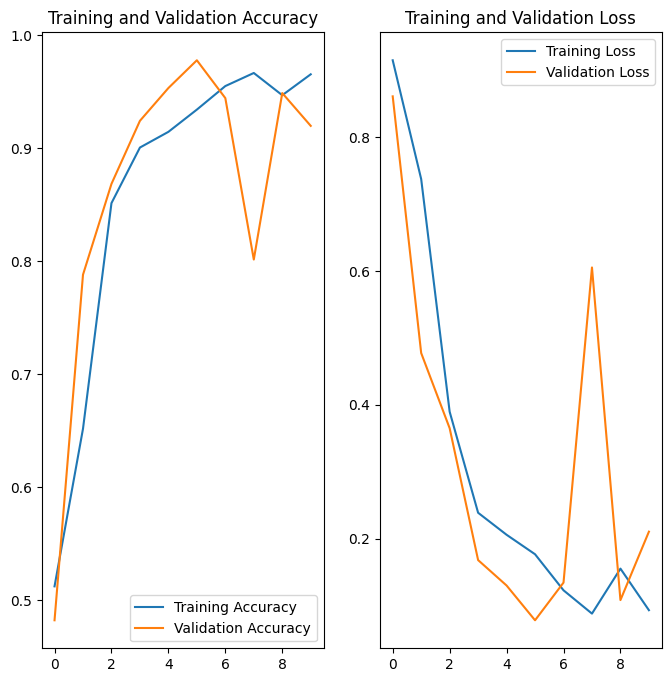

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 699ms/step
predicted label: Potato___Early_blight


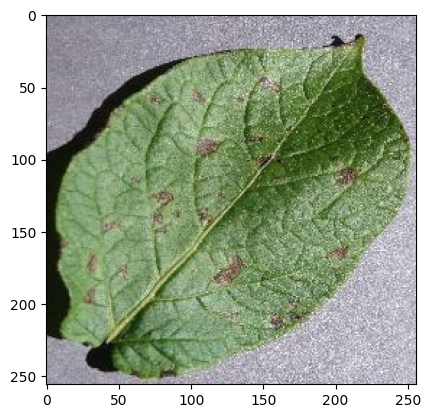

In [ ]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## **Model Prediction**

Now define a function for using our model for prediction about disease or not on applying the external data images.

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


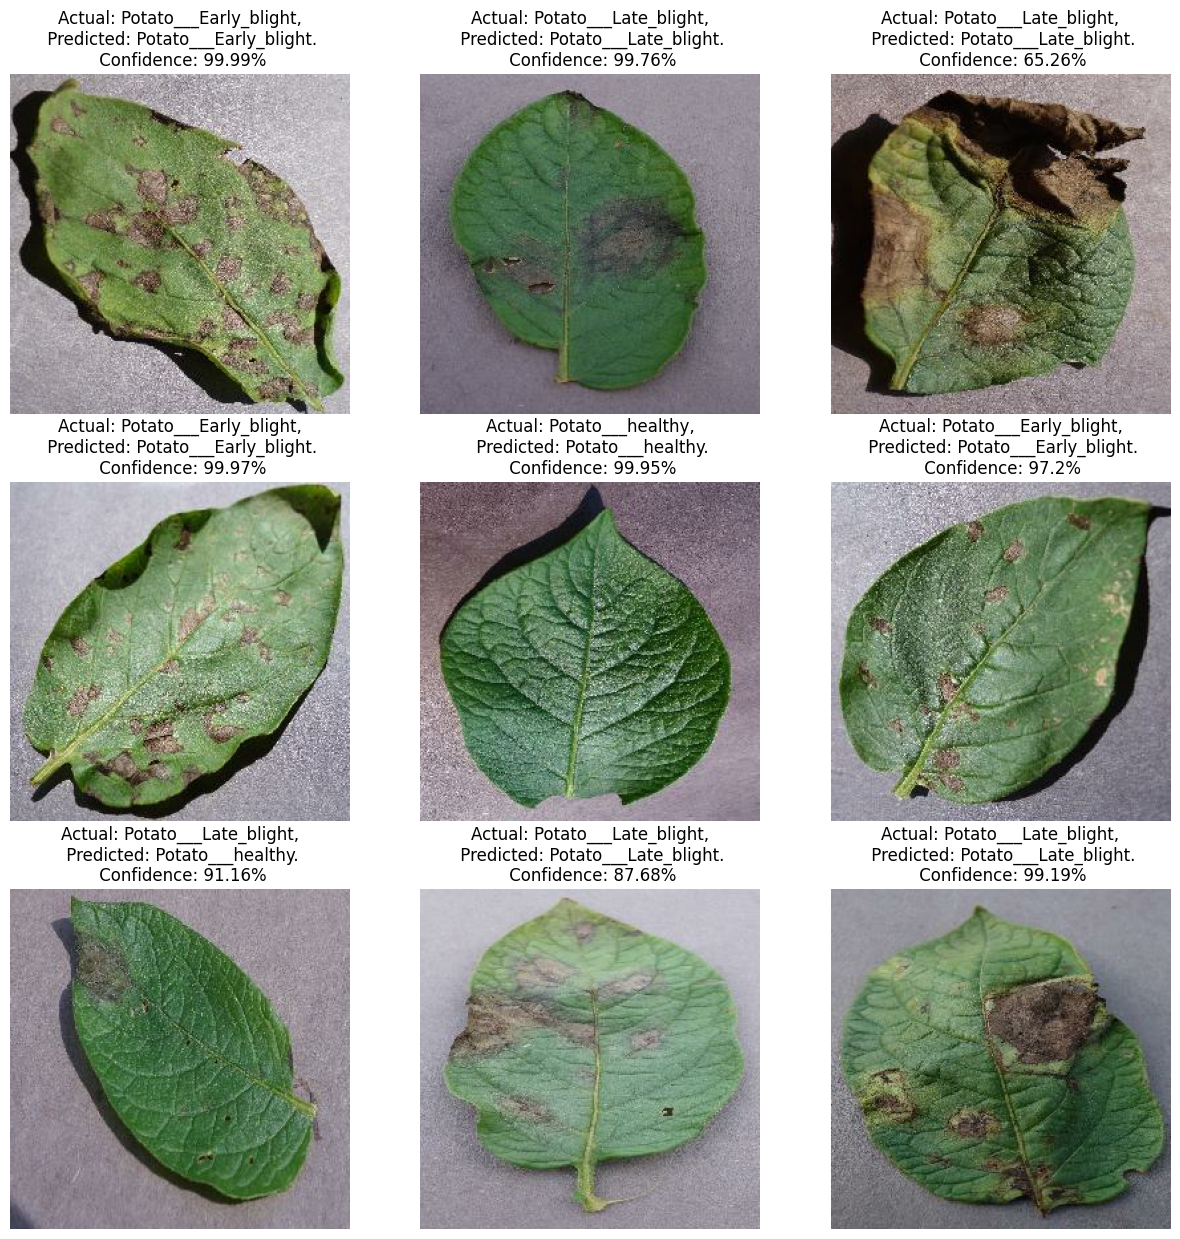

In [ ]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

## **Saving model**

Saved the model in external files that we use in our project

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/MODEL_STORE") + [0]])+1
model.save(f"/content/drive/MyDrive/MODEL_STORE/{model_version}")

In [ ]:
model.save("/content/model_store/potatoes.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
